# Customer Purchase Prediction of OJ Type

One cup of fresh orange juice has 124 mg of vitamin C, which is 200% of the recommended daily intake of vitamin C for an adult. With this as (completely unrelated) motivation, your task is to build a model to predict whether a grocery store customer will Purchase Citrus Hill (CH) or Minute Maid (MM) orange juice.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, log_loss, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

## Data Understanding

In [56]:
df = pd.read_csv("https://raw.githubusercontent.com/jdonvl/MMASandbox/master/data/OJ.csv")

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1070 non-null   int64  
 1   Purchase        1070 non-null   object 
 2   WeekofPurchase  1070 non-null   int64  
 3   StoreID         1070 non-null   int64  
 4   PriceCH         1070 non-null   float64
 5   PriceMM         1070 non-null   float64
 6   DiscCH          1070 non-null   float64
 7   DiscMM          1070 non-null   float64
 8   SpecialCH       1070 non-null   int64  
 9   SpecialMM       1070 non-null   int64  
 10  LoyalCH         1070 non-null   float64
 11  SalePriceMM     1070 non-null   float64
 12  SalePriceCH     1070 non-null   float64
 13  PriceDiff       1070 non-null   float64
 14  Store7          1070 non-null   object 
 15  PctDiscMM       1070 non-null   float64
 16  PctDiscCH       1070 non-null   float64
 17  ListPriceDiff   1070 non-null   f

In [58]:
df.head()

,Unnamed: 0,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [59]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [60]:
# Is the target balanced?
count_col=df['Purchase']
pd.concat([count_col.value_counts(), 
                count_col.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))

,counts,percentage
CH,653,61.028037
MM,417,38.971963


In [61]:
df['Purchase'] = df['Purchase'].apply(lambda x: 1 if x=="MM" else 0)

array([[<AxesSubplot:title={'center':'DiscCH'}>,
        <AxesSubplot:title={'center':'DiscMM'}>,
        <AxesSubplot:title={'center':'ListPriceDiff'}>,
        <AxesSubplot:title={'center':'LoyalCH'}>],
       [<AxesSubplot:title={'center':'PctDiscCH'}>,
        <AxesSubplot:title={'center':'PctDiscMM'}>,
        <AxesSubplot:title={'center':'PriceCH'}>,
        <AxesSubplot:title={'center':'PriceDiff'}>],
       [<AxesSubplot:title={'center':'PriceMM'}>,
        <AxesSubplot:title={'center':'Purchase'}>,
        <AxesSubplot:title={'center':'SalePriceCH'}>,
        <AxesSubplot:title={'center':'SalePriceMM'}>],
       [<AxesSubplot:title={'center':'SpecialCH'}>,
        <AxesSubplot:title={'center':'SpecialMM'}>,
        <AxesSubplot:title={'center':'StoreID'}>,
        <AxesSubplot:title={'center':'WeekofPurchase'}>]], dtype=object)

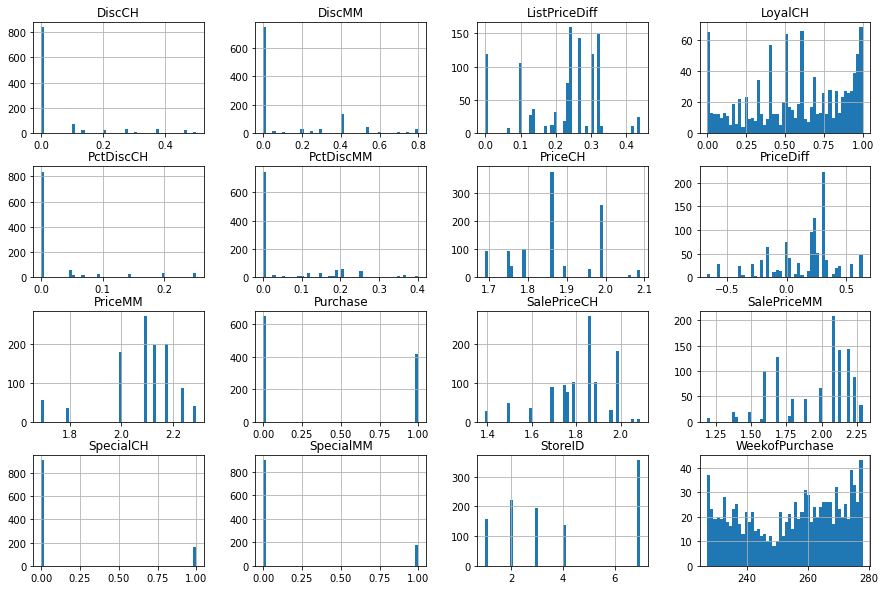

In [62]:
# Univariate analysis of numerical features
df.loc[:, ['Purchase','WeekofPurchase','StoreID','PriceCH','PriceMM','DiscCH','DiscMM','SpecialCH','SpecialMM','LoyalCH','SalePriceMM','SalePriceCH','PriceDiff','PctDiscMM','PctDiscCH','ListPriceDiff']].hist(bins=50, figsize=(15,10))
plt.show()

In [63]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="dodgerblue", lw=4),
                Line2D([0], [0], color="orange", lw=4)]

In [64]:
# Univariate analysis of numerical features versus Target
## Code inspired by: https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook
## Histogram stylization from: https://www.machinelearningplus.com/plots/matplotlib-histogram-python-examples/
## Custom Legends: Custom Legend https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
def draw_distplot(df, variables, n_rows, n_cols, title):
    fig=plt.figure(figsize=(15,15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if var_name=="WeekofPurchase" or var_name=="StoreID"or var_name=="STORE":
            sns.distplot(df.loc[df.Purchase==1, var_name] , color="dodgerblue", ax=ax, axlabel=False, kde=True)
            sns.distplot(df.loc[df.Purchase==0, var_name] , color="orange", ax=ax, axlabel=False, kde=True)
        else:
            sns.distplot(df.loc[df.Purchase==1, var_name] , color="dodgerblue", ax=ax, axlabel=False, kde=True, kde_kws={'bw': 0.1})
            sns.distplot(df.loc[df.Purchase==0, var_name] , color="orange", ax=ax, axlabel=False, kde=True, kde_kws={'bw': 0.1})
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    fig.legend(custom_lines, ['1', '0'], loc='upper right')
    fig.suptitle(title, fontsize=16, y=1.08)
    plt.show()

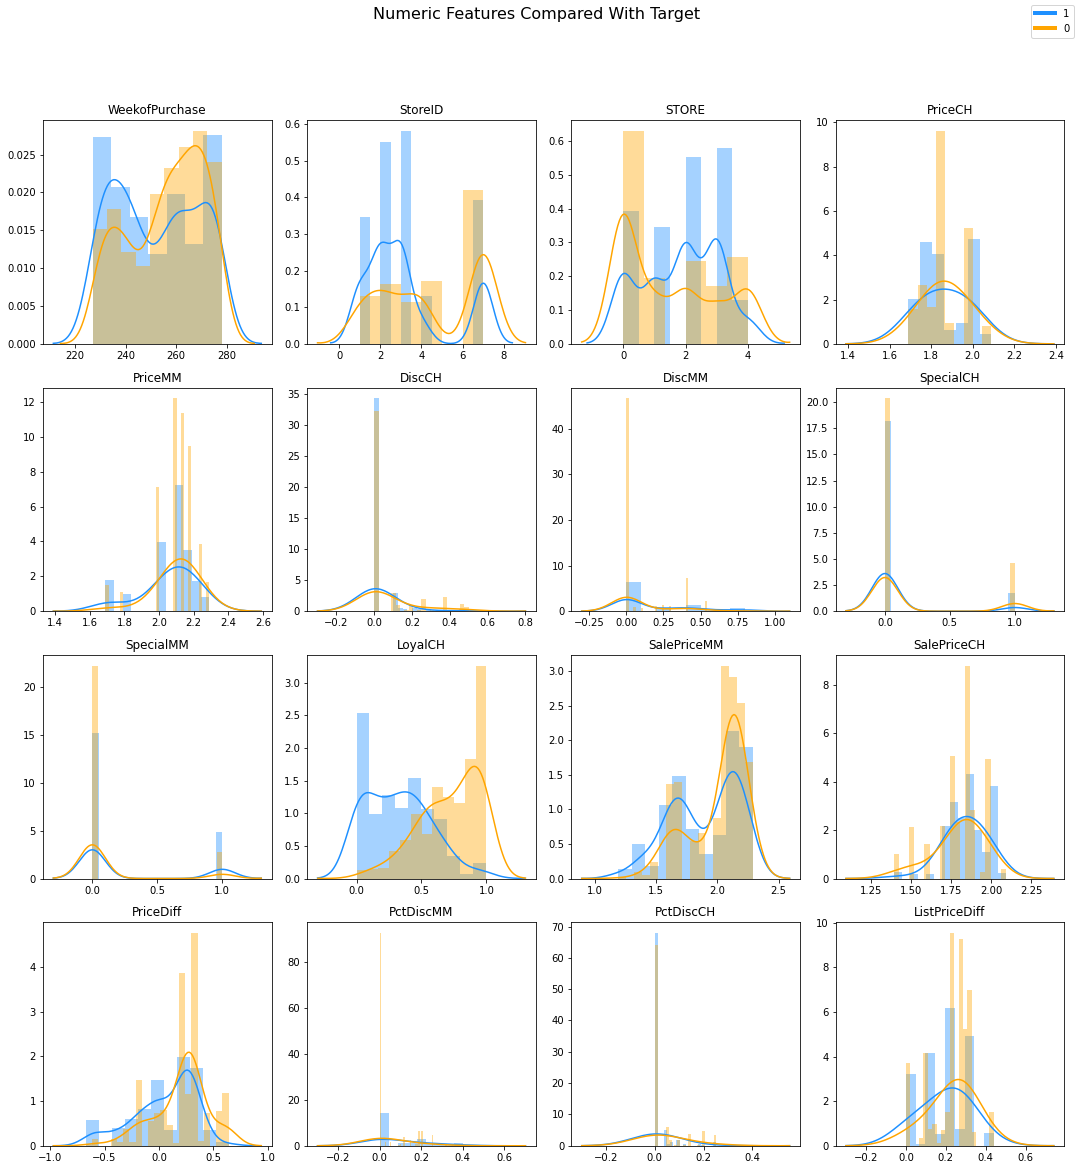

In [65]:
draw_distplot(df, ['WeekofPurchase','StoreID','STORE','PriceCH','PriceMM','DiscCH','DiscMM','SpecialCH','SpecialMM','LoyalCH','SalePriceMM','SalePriceCH','PriceDiff','PctDiscMM','PctDiscCH','ListPriceDiff'], 4, 4, "Numeric Features Compared With Target")

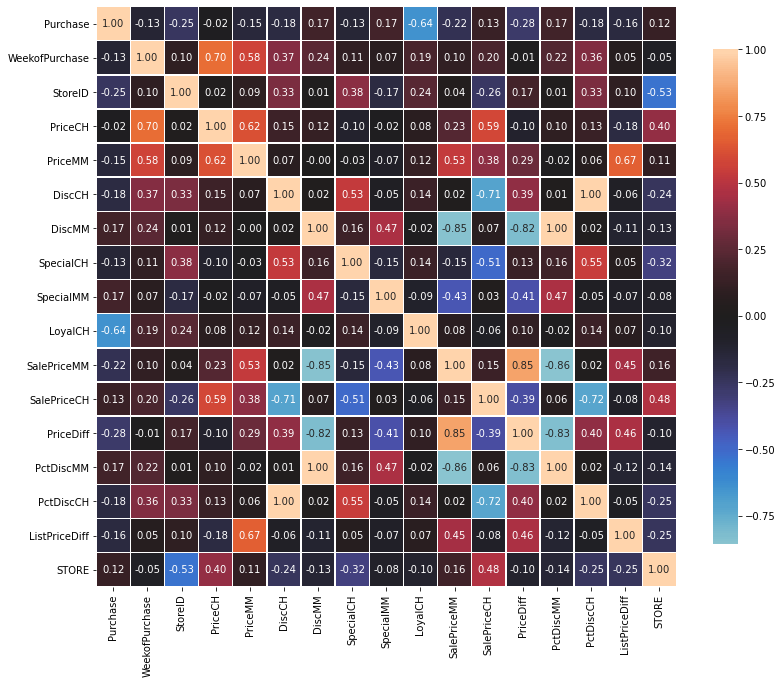

In [66]:
# Correlation Matrix
## Code modified from: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(13,13))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

## Data Preparation

Store and Week of Purchase are categorical values. Although the actual values are numeric, they should be treated as categorical because the values of the numbers do not relate to each other. Each value represents a seperate category. These are all One Hot Encoded.

The continuous variables are scaled using standard scaling. Scaling is generally a best practice and generally improves the numerical stability of some algorithms. 

In [67]:
dep_var = ['Purchase']

#STORE and StoreID have the same information
categorical_vars = ['STORE', 'Store7', 'WeekofPurchase']

continuous_vars = ['PriceCH','PriceMM','DiscCH','DiscMM','SpecialCH','SpecialMM','LoyalCH','SalePriceMM','SalePriceCH','PriceDiff','PctDiscMM','PctDiscCH','ListPriceDiff']

In [68]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

cat_transformers = [('cat', cat_pipe, categorical_vars)]

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scl', StandardScaler())])

num_transformers = [('num', num_pipe,  continuous_vars)]

In [69]:
preprocessor = ColumnTransformer(transformers=cat_transformers + num_transformers)

## Modeling

The data was split into a training and testing set with an 80-20 ratio. Splitting into training and testing allows us to train using the training data, and the test on an unseen data set to see if our model generalizes to new data.

In [70]:
X = df[categorical_vars+continuous_vars]
y = df[dep_var]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20,random_state=0)

In [71]:
models = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    RandomForestClassifier(max_depth=8, random_state=0),
    SVC(gamma='auto'),
    GradientBoostingClassifier(random_state=0)
]

In [72]:
# Function modified from: https://www.scikit-yb.org/en/latest/tutorial.html

def score_model_test(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', estimator)])
    
    pipe.fit(X,y)
    y_pred = pipe.predict(X_test)
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{} accuracy: {}%".format(estimator.__class__.__name__, round(pipe.score(X_test, y_test)*100, 3)))

    #for k, v in pipe.get_params().items():
    #    if k.startswith('classifier'):
    #        print(k, v)

for model in models:
    score_model_test(X_train, np.ravel(y_train), model)

LogisticRegression accuracy: 82.71%
KNeighborsClassifier accuracy: 76.636%
RandomForestClassifier accuracy: 80.841%
SVC accuracy: 82.243%
GradientBoostingClassifier accuracy: 81.308%


### Train-Test Split Results Commentary
Our 3 best models were Logistic Regression, SVC, and XGBoost. We will tune hyperparameters for these.

### Hyperparameter Tuning

We used 5 fold CV for hyperparameter tuning on the training set. Here we still reserved the test set to see how well the models generalize.

In [117]:
models_cv = [
    (LogisticRegression(max_iter=500, solver='liblinear'),{'classifier__C': [0.1, 1, 10], 'classifier__penalty' : ['l1', 'l2']}),
    (SVC(gamma='auto'),{'classifier__C': [1, 10, 100], 'classifier__kernel': ['linear', 'rbf']}),
    (GradientBoostingClassifier(),{'classifier__max_depth': [3, 5, 7], 'classifier__min_samples_split' : [2, 4, 6], 'classifier__n_estimators' : [100, 200]})
]

In [118]:
data = []

In [119]:
# Modified from: https://www.scikit-yb.org/en/latest/tutorial.html

def score_model_gridsearch(X, y, estimator, param_grid, **kwargs):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', estimator)])
    
    # we pass the model, our parameter grid, and cross-validation parameters to the class
    grid_search = GridSearchCV(estimator=pipe, 
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=5)
    # last, we fit our data. This will take a while...
    grid_search.fit(X=X, y=np.ravel(y))
    print("{} accuracy score: {}%".format(estimator.__class__.__name__, round(grid_search.best_score_*100, 3)))
    print("{} best parameters: {}".format(estimator.__class__.__name__, grid_search.best_params_))
    print("\n",grid_search.best_estimator_)
    print("\n")
    data.append([estimator.__class__.__name__,grid_search.best_params_, round(grid_search.best_score_*100, 3)])
    return grid_search.best_estimator_
    
tuned_model = []
    
for model in models_cv:
    tuned_model.append(score_model_gridsearch(X_train, np.ravel(y_train), model[0], model[1]))

LogisticRegression accuracy score: 83.412%
LogisticRegression best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['STORE', 'Store7',
                                                   'WeekofPurchase']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                         

## Evaluation
We test the 3 tuned models against the holdout set and obtain the accuracy, AUC, and log loss for each. Additionally, we created a classification report to look at the precision, recall, and f1-scores for each class. Finally, I also observed a confusion matrix for each model.

In [121]:
data_test = []

LogisticRegression
test accuracy: 83.645 %
test AUC: 82.983 %
test log loss: 5.649

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       122
           1       0.83      0.78      0.80        92

    accuracy                           0.84       214
   macro avg       0.84      0.83      0.83       214
weighted avg       0.84      0.84      0.84       214



Text(0.5, 1.0, 'Confusion matrix')

<AxesSubplot:title={'center':'Confusion matrix'}>

Text(0.5, 15.0, 'Predicted classes')

Text(33.0, 0.5, 'True Classes')

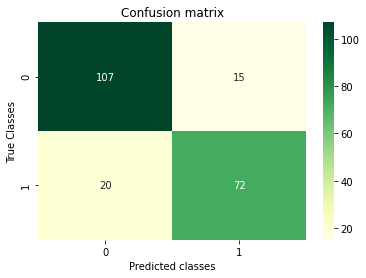

SVC
test accuracy: 82.243 %
test AUC: 81.753 %
test log loss: 6.133

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       122
           1       0.80      0.78      0.79        92

    accuracy                           0.82       214
   macro avg       0.82      0.82      0.82       214
weighted avg       0.82      0.82      0.82       214



Text(0.5, 1.0, 'Confusion matrix')

<AxesSubplot:title={'center':'Confusion matrix'}>

Text(0.5, 15.0, 'Predicted classes')

Text(33.0, 0.5, 'True Classes')

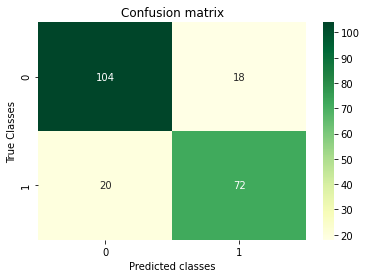

GradientBoostingClassifier
test accuracy: 81.308 %
test AUC: 80.934 %
test log loss: 6.456

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       122
           1       0.78      0.78      0.78        92

    accuracy                           0.81       214
   macro avg       0.81      0.81      0.81       214
weighted avg       0.81      0.81      0.81       214



Text(0.5, 1.0, 'Confusion matrix')

<AxesSubplot:title={'center':'Confusion matrix'}>

Text(0.5, 15.0, 'Predicted classes')

Text(33.0, 0.5, 'True Classes')

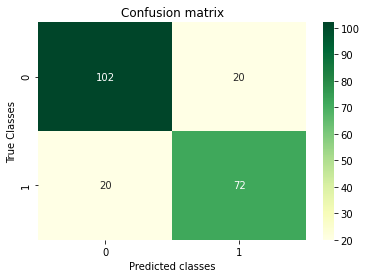

In [122]:
for i in range(3):
    y_hat = tuned_model[i].predict(X_test)
    print(tuned_model[i]['classifier'].__class__.__name__)
    print('test accuracy:'\
          , round(accuracy_score(y_test, y_hat)*100, 3), '%')
    print('test AUC:'\
          , round(roc_auc_score(y_test, y_hat)*100, 3), '%')
    print('test log loss:'\
          , round(log_loss(y_test, y_hat), 3))
    print('')
    print(classification_report(y_test, y_hat))
    
    #Add to results dataframe
    data_test.append([tuned_model[i]['classifier'].__class__.__name__,round(accuracy_score(y_test, y_hat)*100, 3), round(roc_auc_score(y_test, y_hat)*100, 3),
                round(log_loss(y_test, y_hat), 3)])

    plt.title('Confusion matrix')
    sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap="YlGn",fmt="d")
    plt.xlabel('Predicted classes')
    plt.ylabel('True Classes')
    plt.show()

In [126]:
#https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
cv_results = pd.DataFrame(data, columns=['estimator', 'best_params', 'cv_accuracy'])
test_results = pd.DataFrame(data_test, columns=['estimator', 'test_accuracy','test_AUC','test_log_loss'])
results_df = cv_results.merge(test_results, on='estimator')
#results_df.to_csv('oj_results.csv')
results_df

,estimator,best_params,cv_accuracy,test_accuracy,test_AUC,test_log_loss
0,LogisticRegression,"{'classifier__C': 0.1, 'classifier__penalty': ...",83.412,83.645,82.983,5.649
1,SVC,"{'classifier__C': 1, 'classifier__kernel': 'rbf'}",83.061,82.243,81.753,6.133
2,GradientBoostingClassifier,"{'classifier__max_depth': 3, 'classifier__min_...",81.428,81.308,80.934,6.456
